In [1]:
from test import read_data
import pandas as pd

edges = read_data('reddit')

In [2]:
sorted_edges = sorted(edges, key=lambda edge: edge[2])
sorted_edges = [[edge[0], edge[1]] for edge in sorted_edges]

In [3]:
from gensim.models import Word2Vec

embedding_model = Word2Vec(
    vector_size=128, epochs=10, window=10, 
    min_count=1, sg=1, workers=6
)

In [4]:
def train_model_with_walks(embedding_model, walks):
    if not embedding_model.wv.key_to_index:
        embedding_model.build_vocab([[str(node) for node in walk] for walk in walks])
    else:
        embedding_model.build_vocab([[str(node) for node in walk] for walk in walks], update=True)

    string_walks = [[str(node) for node in walk] for walk in walks]
    embedding_model.train(string_walks, total_examples=len(walks), epochs=10)

In [5]:
train_model_with_walks(embedding_model, sorted_edges)

In [6]:
def get_embedding_for_all_nodes(embedding_model):
    return {int(node): embedding_model.wv[node] for node in embedding_model.wv.index_to_key}

In [7]:
embedding_dict = get_embedding_for_all_nodes(embedding_model)

In [1]:
import random
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import spearmanr, pearsonr

def validate_embeddings(embedding_dict, interaction_dict):
    random.seed(42)
    filtered_pairs = [(i, j) for i, j in interaction_dict.keys() if i != j]
    
    similarities = []
    interaction_strengths = []
    
    for i, j in filtered_pairs:
        sim = cosine(embedding_dict[i], embedding_dict[j])
        similarities.append(sim)
        
        interaction_strengths.append(interaction_dict[(i, j)])
    
    pearson_corr, _ = pearsonr(similarities, interaction_strengths)
    spearman_corr, _ = spearmanr(similarities, interaction_strengths)
    
    return similarities, interaction_strengths, pearson_corr, spearman_corr

In [9]:
edges = read_data('reddit')
df = pd.DataFrame(edges, columns=['u', 'i', 't'])

df['pair'] = df.apply(lambda row: tuple(sorted([row['u'], row['i']])), axis=1)
interaction_counts = df['pair'].value_counts()
interaction_dict = interaction_counts.to_dict()

In [10]:
distances, interaction_strengths, pearson_corr, spearman_corr = validate_embeddings(embedding_dict, interaction_dict)

In [11]:
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: -0.10104110343762529
Spearman Correlation: -0.18620387270056743


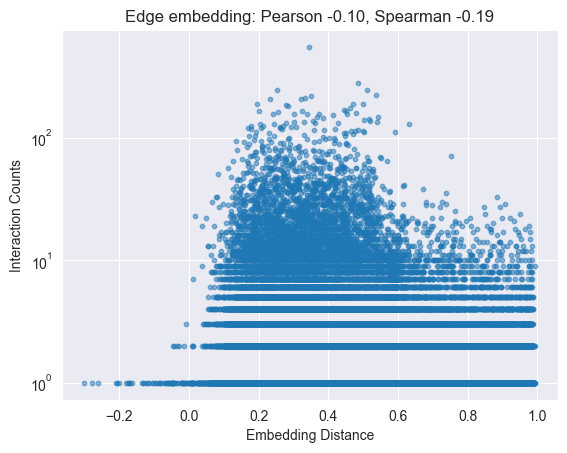

In [16]:
import matplotlib.pyplot as plt

plt.scatter(distances, interaction_strengths, alpha=0.5, s=10)
plt.title(f"Edge embedding: Pearson {pearson_corr:.2f}, Spearman {spearman_corr:.2f}")
plt.xlabel("Embedding Distance")
plt.ylabel("Interaction Counts")
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/edge_embedding_skipgram.png')
plt.show()